In [ ]:
import torch
from torch import nn
import numpy as np
%pip install torchnet
from torchnet.dataset.batchdataset import transform
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import os
# MNIST-SVHN multi-modal model specification

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset, ResampleDataset

def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

class encoder(nn.Module):
    def __init__(self,dimz,channels=3,var_x=0.1):
        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        # self.conv1 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32,
                               kernel_size=4, stride=2, padding=1)

        self.relu = nn.ReLU()

        # self.conv2 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=4, stride=2, padding=1) #YOUR CODE HERE

        # self.conv3 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=4, stride=2, padding=1)

        # self.conv4 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64,
                               kernel_size=4, stride=2, padding=1)  #YOUR CODE HERE

        # self.conv5 is a convolutional layer, with 256 output channels, kernel size 4, stride 1,
        # and padding 0

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=256,
                               kernel_size=4, stride=1, padding=0)


        # self.linear is a linear layer with dimz*2 outputs
        self.linear = nn.Linear(256,dimz*2) #YOUR CODE HERE

        self.softplus = nn.Softplus()

    def forward(self,x):
        # The forward method to project and image into a 2dimz dimensional vector
        z = self.relu(self.conv1(x))
        z = self.relu(self.conv2(z)) #YOUR CODE HERE
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z)) #YOUR CODE HERE
        z = self.relu(self.conv5(z))
        # Transform z into a 256-dim vector
        z = z.view(-1,256) #YOUR CODE HERE
        z = self.linear(z)

        return z





    def encode_and_sample(self,x,flag_sample=True):
        # This methods compute both the posterior mean and variance
        # Also we obtain a sample from the posterior using the
        # reparameterization trick.

        # We obtain the encoder projection using the forward method
        z = self.forward(x) #YOUR CODE HERE

        # The mean is the first dimz components of the forward output

        mu = z[:, :self.dimz] #YOUR CODE HERE

        # We compute the variance from the last dimz components using a
        # soft plus
        var = self.softplus(0.5 * z[:, self.dimz:])

        sample = None

        if(flag_sample==True):

            eps = torch.randn_like(var)

            sample = mu + eps*(var**0.5)

        return mu,var,sample


class decoder(nn.Module):
    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()

        # We expand z into a 256 dimensional vector

        self.linear = nn.Linear(dimz,256)

        self.relu = nn.ReLU()

        self.tanh = nn.Tanh()

        # self.tconv1 is a convolutional layer, with 64 output channels, kernel size 4, stride 1,
        # and padding 0

        self.tconv1 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=1,padding=0)

        # self.tconv2 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2,padding=1) #YOUR CODE HERE

        # self.tconv3 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1)

        # self.tconv3 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv4 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,padding=1) #YOUR CODE HERE

        # self.tconv3 is a convolutional layer, with channels output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv5 = nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2,padding=1)

    def forward(self,z):

        x = self.relu(self.linear(z).view(-1,256,1,1))
        x = self.relu(self.tconv1(x)) #YOUR CODE HERE
        x = self.relu(self.tconv2(x))
        x = self.relu(self.tconv3(x)) #YOUR CODE HERE
        x = self.relu(self.tconv4(x))
        x = self.tanh(self.tconv5(x)) #YOUR CODE HERE
        return x

    def decode(self,z):

        # This function simply calls the forward method

        return self.forward(z)


def getDataLoaders(batch_size, transform, shuffle=True, device='cuda'):
        if not (os.path.exists('./data/train-ms-mnist-idx.pt')
                and os.path.exists('./data/train-ms-svhn-idx.pt')) :
           #     and os.path.exists('./data/test-ms-mnist-idx.pt')
            #    and os.path.exists('./data/test-ms-svhn-idx.pt')):
            raise RuntimeError('Generate transformed indices with the script in bin')
        # get transformed indices
        t_mnist = torch.load('./data/train-ms-mnist-idx.pt')
        t_svhn = torch.load('./data/train-ms-svhn-idx.pt')
        #s_mnist = torch.load('./data/test-ms-mnist-idx.pt')
        #s_svhn = torch.load('./data/test-ms-svhn-idx.pt')

        # load base datasets
        t1 = mnist_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform[0], download=True)
        t2 = shvn_train_dataset = datasets.SVHN(root='./data', split='train',transform=transform[1], download=True)

        train_mnist_svhn = TensorDataset([
            ResampleDataset(t1, lambda d, i: t_mnist[i], size=len(t_mnist)),
            ResampleDataset(t2, lambda d, i: t_svhn[i], size=len(t_svhn))
        ])
        print(type(t1))
        print(type(ResampleDataset(t1, lambda d, i: t_mnist[i], size=len(t_mnist))))
        # test_mnist_svhn = TensorDataset([
        #    ResampleDataset(s1.dataset, lambda d, i: s_mnist[i], size=len(s_mnist)),
        #    ResampleDataset(s2.dataset, lambda d, i: s_svhn[i], size=len(s_svhn))
        # ])

        kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {}
        print(type(train_mnist_svhn))
        train = DataLoader(train_mnist_svhn, batch_size=batch_size, shuffle=shuffle, **kwargs)
        print(type(train))
        #test = DataLoader(test_mnist_svhn, batch_size=batch_size, shuffle=shuffle, **kwargs)
        return train #, test


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29728 sha256=d897f7f120b57cb1f6d7c7d8fbaceab0789bc9b5a83a7c17e32fec1538c2b51e
  Stored in directory: /root/.cache/pip/wheels/f7/ae/94/9f5edd6871983f30967ad11d60ef434c3d1b007654de4c8065
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408194 sha256=ff186475a991a222248dfcae312a5dabb061b5382f3fc77c4fec4bf7bd51ea78
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built torchnet visdom


In [ ]:
import torch
from torchvision import datasets, transforms

def rand_match_on_idx(l1, idx1, l2, idx2, max_d=10000, dm=10):
    """
    l*: sorted labels
    idx*: indices of sorted labels in original list
    """
    _idx1, _idx2 = [], []
    for l in l1.unique():  # assuming both have same idxs
        l_idx1, l_idx2 = idx1[l1 == l], idx2[l2 == l]
        n = min(l_idx1.size(0), l_idx2.size(0), max_d)
        l_idx1, l_idx2 = l_idx1[:n], l_idx2[:n]
        for _ in range(dm):
            _idx1.append(l_idx1[torch.randperm(n)])
            _idx2.append(l_idx2[torch.randperm(n)])
    return torch.cat(_idx1), torch.cat(_idx2)

if __name__ == '__main__':
    max_d = 10000  # maximum number of datapoints per class
    dm = 30        # data multiplier: random permutations to match

    # get the individual datasets
    tx = transforms.ToTensor()
    train_mnist = datasets.MNIST('./data', train=True, download=True, transform=tx)
    test_mnist = datasets.MNIST('./data', train=False, download=True, transform=tx)
    train_svhn = datasets.SVHN('./data', split='train', download=True, transform=tx)
    test_svhn = datasets.SVHN('./data', split='test', download=True, transform=tx)
    # svhn labels need extra work
    train_svhn.labels = torch.LongTensor(train_svhn.labels.squeeze().astype(int)) % 10
    test_svhn.labels = torch.LongTensor(test_svhn.labels.squeeze().astype(int)) % 10

    mnist_l, mnist_li = train_mnist.targets.sort()
    svhn_l, svhn_li = train_svhn.labels.sort()
    idx1, idx2 = rand_match_on_idx(mnist_l, mnist_li, svhn_l, svhn_li, max_d=max_d, dm=dm)
    print('len train idx:', len(idx1), len(idx2))
    torch.save(idx1, './data/train-ms-mnist-idx.pt')
    torch.save(idx2, './data/train-ms-svhn-idx.pt')

    mnist_l, mnist_li = test_mnist.targets.sort()
    svhn_l, svhn_li = test_svhn.labels.sort()
    idx1, idx2 = rand_match_on_idx(mnist_l, mnist_li, svhn_l, svhn_li, max_d=max_d, dm=dm)
    print('len test idx:', len(idx1), len(idx2))
    torch.save(idx1, './data/test-ms-mnist-idx.pt')
    torch.save(idx2, './data/test-ms-svhn-idx.pt')



100%|██████████| 9912422/9912422 [00:00<00:00, 84718546.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105152512.00it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27303379.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4554274.15it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 182040794/182040794 [00:17<00:00, 10114035.08it/s]


100%|██████████| 64275384/64275384 [00:12<00:00, 5278276.70it/s]


len train idx: 1682040 1682040
len test idx: 300000 300000


In [ ]:
from torchnet.dataset.batchdataset import transform

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim, sqrt
import time
from os import listdir
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np

def eval_Gaussian_LL(x,mu_x,var_x):
    # x is a mini-batch of images. It has dimension [Batch,3,dimx,dimx]
    # mu_x is a mini-batch of reconstructed images. It has dimension [Batch,3,dimx,dimx]
    # var_x is a torch constant
    D = x.shape[1] * x.shape[2] * x.shape[3]   # Dimension of the image

    x = x.reshape(-1, D)

    mu_x = mu_x.reshape(-1, D)

    var_x = torch.ones_like(mu_x) * var_x

    # Constant term in the gaussian distribution
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # log-likelihood per datapoint

    logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))

    logp = torch.sum(logp_data)

    return logp,logp_data


class MVAE(nn.Module):
    def __init__(self,dimz,channels=[3,3],var_x=0.1):

        super().__init__()

        self.var_x = var_x

        self.dimz = dimz

        # We create two encoder network

        self.encoder_1 = encoder(self.dimz,channels[0],var_x) #YOUR CODE HERE
        self.encoder_2 = encoder(self.dimz,channels[1],var_x) #YOUR CODE HERE

        # We create two decoder network

        self.decoder_1 = decoder(self.dimz,channels[0],var_x) #YOUR CODE HERE
        self.decoder_2 = decoder(self.dimz,channels[1],var_x) #YOUR CODE HERE


    def forward(self,x_1, x_2):

        # In the forward method, we return the mean and variance
        # given by the encoder network and also the reconstruction mean
        # given by the decoder network using a sample from the
        # encoder's posterior distribution.

        mu_1,var_1,_ = self.encoder_1.encode_and_sample(x_1) #YOUR CODE HERE
        mu_2,var_2,_ = self.encoder_2.encode_and_sample(x_2) #YOUR CODE HERE
        # Generate the joint latent space -> N(m, C)
        C = 1/(1/var_1 + 1/var_2)
        m = C*(var_1*mu_1 + var_2*mu_2)
        # Sample from the latent space
        eps = torch.randn_like(C)
        sample_z = eps * sqrt(C) + m
        # Decoder provides the mean of the reconstruction
        mu_x_1 = self.decoder_1.decode(sample_z)
        mu_x_2 = self.decoder_2.decode(sample_z)
        return mu_x_1, mu_x_2 ,m,C #TODO ricordati di modificare la parte del training in modo che usi mu_x_2

    def mnist_to_both(self, x_1):


        x_1,_ = x_1
        x_1 = x_1.to(self.device)
        mu_1,var_1,_ = self.encoder_1.encode_and_sample(x_1) #YOUR CODE HERE

        C = var_1
        m =  mu_1
        eps = torch.randn_like(C)
        sample_z = eps * sqrt(C) + m
        # Decoder provides the mean of the reconstruction
        mu_x_1 = self.decoder_1.decode(sample_z)
        mu_x_2 = self.decoder_2.decode(sample_z)
        return mu_x_1, mu_x_2 ,m,C #TODO ricordati di modificare la parte del training in modo che usi mu_x_2



    def svhn_to_both(self, x_2):


        x_2,_ = x_2
        x_2 = x_2.to(self.device)
        mu_2,var_2,_ = self.encoder_2.encode_and_sample(x_2) #YOUR CODE HERE

        C = var_2
        m =  mu_2
        eps = torch.randn_like(C)
        sample_z = eps * sqrt(C) + m
        # Decoder provides the mean of the reconstruction
        mu_x_1 = self.decoder_1.decode(sample_z)
        mu_x_2 = self.decoder_2.decode(sample_z)
        return mu_x_1, mu_x_2 ,m,C #TODO ricordati di modificare la parte del training in modo che usi mu_x_2




    # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, x_1, x_2, mu_x_1, mu_x_2, mu_z, var_z):

        # We evaluate the loglikelihood in the batch using the function provided above

        logp_1,_ = eval_Gaussian_LL(x_1, mu_x_1,self.var_x)  #the first is for svhn the second one is for mnist
        logp_2,_ = eval_Gaussian_LL(x_2, mu_x_2,self.var_x)

        # KL divergence between q(z) and N()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114

        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # To maximize ELBO we minimize loss (-ELBO)
        return -logp_1 - logp_2/3 + KLz, -logp_1, -logp_2/3, KLz


class MVAE_extended(MVAE):

    def __init__(self, dimz=2,  channels=[3,3], var_x=0.1,lr=1e-3,epochs=20,save_folder='./',restore=False):

        super().__init__(dimz,channels=channels,var_x=0.1)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.save_folder = save_folder

        if(restore==True):
          state_dict = torch.load(self.save_folder+'VAE_checkpoint.pth')
          self.load_state_dict(state_dict)

        self.loss_during_training = []
        self.reconstruc_1_during_training = []
        self.reconstruc_2_during_training = []
        self.KL_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self,trainloader):

        nims = len(trainloader.dataset)

        self.train()

        for e in range(int(self.epochs)):

            train_loss = 0
            train_rec1 = 0
            train_rec2 = 0
            train_kl_l = 0

            idx_batch = 0


            for mnist, shvn in trainloader:
                mnist,_ = mnist
                shvn,_ = shvn
                #images = images.to(self.device)
                mnist = mnist.to(self.device)
                shvn = shvn.to(self.device)
                self.optim.zero_grad()

                mu_mnist, mu_shvn, mu_z, var_z = self.forward(mnist,shvn)

                loss, rec1, rec2, kl_l = self.loss_function(mnist, shvn, mu_mnist, mu_shvn, mu_z, var_z)

                loss.backward()

                train_loss += loss.item()
                train_rec1 += rec1.item()
                train_rec2 += rec2.item()

                train_kl_l += kl_l.item()

                self.optim.step()

                if(idx_batch%10==0):

                  torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')

                idx_batch += 1
                if  idx_batch >=200:
                  break

            self.loss_during_training.append(train_loss/len(trainloader))
            self.reconstruc_1_during_training.append(train_rec1/len(trainloader))
            self.reconstruc_2_during_training.append(train_rec2/len(trainloader))
            self.KL_during_training.append(train_kl_l/len(trainloader))
            print("---------EPOCH{}---------".format(e))
            print('loss: ', train_loss/len(trainloader))
            print('rec1: ', train_rec1/len(trainloader))
            print('rec2: ', train_rec2/len(trainloader))
            print('KL: ', train_kl_l/len(trainloader))

            if(e%1==0):

                torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')
                print('Train Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_training[-1]))


    def sample(self,num_imgs):

      with torch.no_grad():

        eps = torch.randn([num_imgs,self.dimz]).to(self.device)

        mnist_sample = self.decoder_1.decode(eps)
        shvn_sample = self.decoder_2.decode(eps)

        return mnist_sample.to("cpu").detach(), shvn_sample.to("cpu").detach()

    def sample1(self,num_imgs):

      with torch.no_grad():

        eps = torch.randn([num_imgs,self.dimz]).to(self.device)

        mnist_sample = self.decoder_1.decode(eps)
        #shvn_sample = self.decoder_2.decode(eps)

        return mnist_sample.to("cpu").detach(), shvn_sample.to("cpu").detach()


######### MAIN ##########
mnist_trn =  transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
    ])
shvn_trn = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])

multi_view_vae = MVAE_extended(32, channels=[1,3])
trainloader = getDataLoaders(64, transform=[mnist_trn,shvn_trn])#get_mnist_shvn(batch_size=64)
multi_view_vae.trainloop(trainloader)


Using downloaded and verified file: ./data/train_32x32.mat
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchnet.dataset.resampledataset.ResampleDataset'>
<class 'torchnet.dataset.tensordataset.TensorDataset'>
<class 'torch.utils.data.dataloader.DataLoader'>
---------EPOCH0---------
loss:  2478.955745020356
rec1:  1979.8785034672019
rec2:  469.66983267941816
KL:  29.407404716787216
Train Epoch: 0 	Loss: 2478.955745
---------EPOCH1---------
loss:  882.2413049449243
rec1:  734.6658032351039
rec2:  98.2655030497223
KL:  49.30999950469606
Train Epoch: 1 	Loss: 882.241305
---------EPOCH2---------
loss:  391.8239674194791
rec1:  305.47865697055016
rec2:  38.20522515093951
KL:  48.140084290103495
Train Epoch: 2 	Loss: 391.823967
---------EPOCH3---------
loss:  178.94310761717264
rec1:  134.82507570384436
rec2:  1.0789046459896146
KL:  43.03912693038487
Train Epoch: 3 	Loss: 178.943108
---------EPOCH4---------
loss:  14.9899073183405
rec1:  14.697008082279014
rec2:  -40.23849787609407
KL

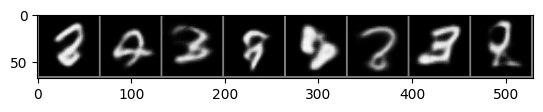

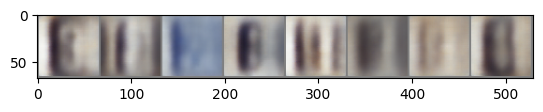

In [ ]:
a,b = multi_view_vae.sample(8)
#print(a)
#print(b)


imshow(torchvision.utils.make_grid(a))
imshow(torchvision.utils.make_grid(b))




In [ ]:
data = iter(trainloader)
mnist, svhn = next(data)

a,b,c,d = multi_view_vae.mnist_to_both(mnist)

#m1,m2 = mnist

#print(m2)

imshow(torchvision.utils.make_grid(a.to("cpu")))
imshow(torchvision.utils.make_grid(b.to("cpu")))

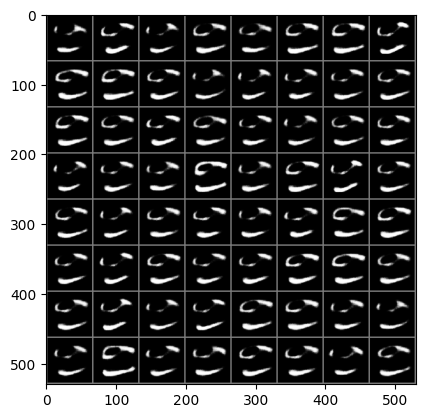

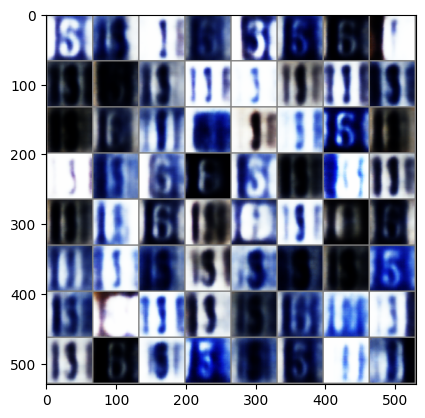

In [ ]:
data = iter(trainloader)
mnist, svhn = next(data)

a,b,c,d = multi_view_vae.svhn_to_both(svhn)

#m1,m2 = mnist

#print(m2)

imshow(torchvision.utils.make_grid(a.to("cpu")))
imshow(torchvision.utils.make_grid(b.to("cpu")))